# Deep learning for timeseries

## A temperature-forecasting example

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
from matplotlib import pyplot as plt

2025-06-22 03:07:19.689332: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-22 03:07:19.751773: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Inspecting the data of the Jena weather dataset

fname = os.path.join("/tf-gpu/media/deep_learning_with_python/10_time_series/jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Now, convert all 420,551 lines of data into NumPy arrays: one array for the temperature (in degrees Celsius), and another one for the rest of the data—the features we will use to predict future temperatures. Note that we discard the “Date Time” column.

In [3]:
# Parsing the data

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

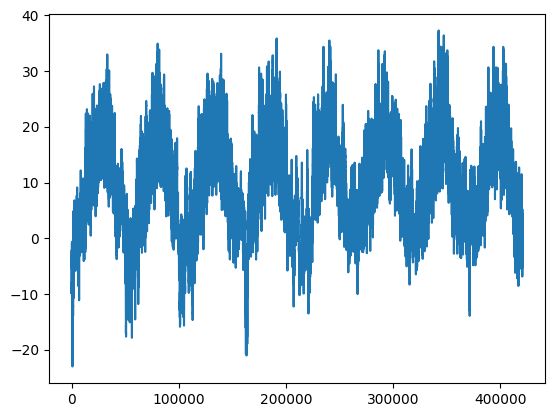

In [4]:
# Plotting the temperature timeseries

plt.plot(range(len(temperature)), temperature)

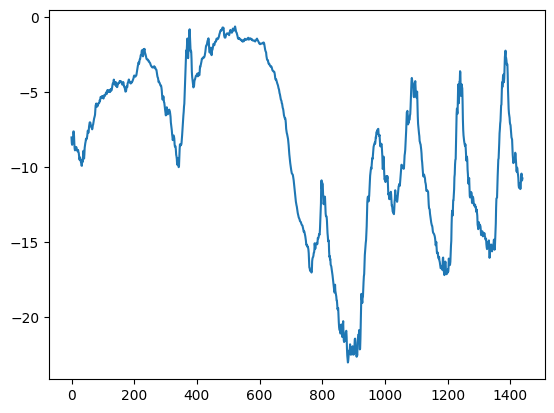

In [5]:
# Plotting the first 10 days of the temperature timeseries

plt.plot(range(1440), temperature[:1440])

In all our experiments, we’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing.

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

The exact formulation of the problem will be as follows: given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

First, let’s preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do any vectorization. But each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in mbar, is around 1,000, while H2OC, measured in millimoles per mole, is around 3). We’ll normalize each timeseries independently so that they all take small values on a similar scale. We’re going to use the first 210,225 timesteps as training data, so we’ll compute the mean and standard deviation only on this fraction of the data.

In [7]:
# Normalizing the data

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

We’ll use timeseries_dataset_from_array() to instantiate three datasets: one for training, one for validation, and one for testing. You can generally use it for any kind of timeseries forecasting task.


We’ll use the following parameter values:

sampling_rate = 6—Observations will be sampled at one data point per hour: we will only keep one data point out of 6.

sequence_length = 120—Observations will go back 5 days (120 hours).

delay = sampling_rate * (sequence_length + 24 - 1)—The target for a sequence will be the temperature 24 hours after the end of the sequence.

When making the training dataset, we’ll pass start_index = 0 and end_index = num_train_samples to only use the first 50% of the data. For the validation dataset, we’ll pass start_index = num_train_samples and end_index = num_train_samples + num_val_samples to use the next 25% of the data. Finally, for the test dataset, we’ll pass start_index = num_train_samples + num_val_samples to use the remaining samples.

In [8]:
# Instantiating datasets for training, validation, and testing

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

2025-06-22 03:08:25.296572: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-22 03:08:25.328260: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-22 03:08:25.328329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-22 03:08:25.331500: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-22 03:08:25.331534: I external/local_xla/xla/stream_executor

### A common-sense, non-machine-learning baseline

Before we start using black-box deep learning models to solve the temperature-prediction problem, let’s try a simple, common-sense approach. It will serve as a sanity check, and it will establish a baseline that we’ll have to beat in order to demonstrate the usefulness of more-advanced machine learning models.

In this case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. Thus a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now. Let’s evaluate this approach, using the mean absolute error (MAE) metric, defined as follows:

In [9]:
# Computing the common-sense baseline MAE

def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

2025-06-21 00:57:03.648001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation MAE: 2.44
Test MAE: 2.62


2025-06-21 00:57:05.852493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


This common-sense baseline achieves a validation MAE of 2.44 degrees Celsius and a test MAE of 2.62 degrees Celsius. So if you always assume that the temperature 24 hours in the future will be the same as it is now, you will be off by two and a half degrees on average. It’s not too bad, but you probably won’t launch a weather forecasting service based on this heuristic. Now the game is to use your knowledge of deep learning to do better.

### A first recurrent baseline: A simple Long Short Term Memory (LSTM) - based model

There’s a family of neural network architectures designed specifically for this use case: recurrent neural networks. Among them, the Long Short Term Memory (LSTM) layer has long been very popular. We’ll see in a minute how these models work, but let’s start by giving the LSTM layer a try.

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 73.0351 - mae: 6.5153 - val_loss: 12.4530 - val_mae: 2.6971
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 12.0255 - mae: 2.6780 - val_loss: 9.6415 - val_mae: 2.4157
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 10.1721 - mae: 2.4801 - val_loss: 9.7067 - val_mae: 2.4130
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 9.6540 - mae: 2.4177 - val_loss: 9.8746 - val_mae: 2.4300
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 9.4047 - mae: 2.3872 - val_loss: 9.9304 - val_mae: 2.4270
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 9.1756 - mae: 2.3576 - val_loss: 9.5068 - val_mae: 2.3778
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 9.0317 - mae: 2.3366 - val_loss: 9.8944 - val_mae: 2.4274
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 8.8910 - mae: 2.3220 - val_loss: 10.1073 - val_mae: 2.4377
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━

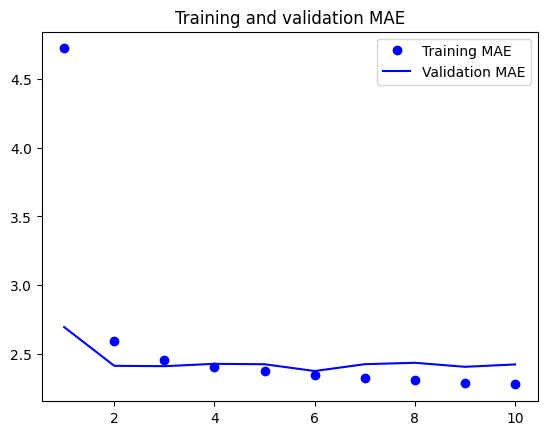

In [24]:
# Plotting results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

We achieve a validation MAE as low as 2.3778 degrees and a test MAE of 2.65 degrees. There is a improvement of 2.6% in validation mae compared to our non machine learning baseline, but a worst test mae 2.65 vs 2.62 baseline. Let's see if we can do it better.

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization. In 2016, Yarin Gal, as part of his PhD thesis on Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of using a dropout mask that varies randomly from timestep to timestep. What’s more, in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a recurrent dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras has two dropout-related arguments: dropout, a float specifying the dropout rate for input units of the layer, and recurrent_dropout, specifying the dropout rate of the recurrent units. Let’s add recurrent dropout to the LSTM layer of our first LSTM example and see how doing so impacts overfitting.

Thanks to dropout, we won’t need to rely as much on network size for regularization, so we’ll use an LSTM layer with twice as many units, which should, hopefully, be more expressive (without dropout, this network would have started overfitting right away—try it). Because networks being regularized with dropout always take much longer to fully converge, we’ll train the model for five times as many epochs.

In [ ]:
# Training and evaluating a dropout-regularized LSTM

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 187s 227ms/step - loss: 48.1881 - mae: 5.1586 - val_loss: 10.0520 - val_mae: 2.4588
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 192s 234ms/step - loss: 14.9390 - mae: 3.0097 - val_loss: 9.6837 - val_mae: 2.4095
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 182s 222ms/step - loss: 13.7778 - mae: 2.8850 - val_loss: 9.8354 - val_mae: 2.4298
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 181s 221ms/step - loss: 13.2150 - mae: 2.8295 - val_loss: 9.4040 - val_mae: 2.3752
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 181s 221ms/step - loss: 12.6899 - mae: 2.7719 - val_loss: 9.7382 - val_mae: 2.4216
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 178s 217ms/step - loss: 12.1331 - mae: 2.7076 - val_loss: 9.5371 - val_mae: 2.3897
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 179s 219ms/step - loss: 11.8651 - mae: 2.6766 - val_loss: 9.8821 - val_mae: 2.4415
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 182s 222ms/step - loss: 11.4857 - mae: 2.6313 - val_loss: 9.5903 - val_mae: 2.4000
Epoch 9/50
819/

In [ ]:
# Evaluating a dropout-regularized LSTM

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - loss: 10.3309 - mae: 2.5654
Test MAE: 2.56


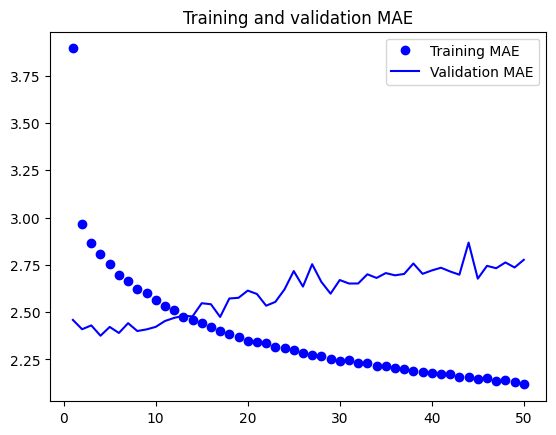

In [8]:
# Plotting results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Success! We’re no longer overfitting during the first 10 epochs. We achieve a validation MAE as low as 2.3752 degrees (2.7% improvement over the no machine learning baseline) and a test MAE of 2.56 degrees (2.3% improvement over the baseline). Not too bad.

**Why dropout matters**

The key insight is that using the same dropout mask across all timesteps prevents the network from learning to compensate for dropout by relying on information from previous timesteps where different units were dropped. This maintains the regularization effect throughout the sequence processing.

Both GRU and LSTM implement these dropout mechanisms identically in Keras. The internal implementation handles the complexity of applying dropout correctly to the recurrent computations while maintaining the time-constant property automatically.
Common dropout values range from 0.1 to 0.5, with recurrent dropout often set slightly lower than input dropout since recurrent connections are typically more critical for sequence modeling performance.

**Standard Dropout (dropout parameter)**

The dropout parameter applies dropout to the input connections at each timestep. This means that for each time step, some input features are randomly set to zero during training. The same dropout mask is applied across all timesteps, which is why it's called "time-constant dropout." 

> gru_layer = GRU(units=64, dropout=0.2)

**Recurrent Dropout (recurrent_dropout parameter)**

The recurrent_dropout parameter applies dropout to the recurrent connections - the connections between hidden states across timesteps. This is crucial because it prevents the network from overfitting to patterns in the temporal dependencies. Like standard dropout, the same mask is applied across all timesteps for consistency.

> lstm_layer = LSTM(units=64, recurrent_dropout=0.2)

**Using Both Together**

You can combine both types of dropout for more robust regularization:

> lstm_layer = LSTM(units=64, dropout=0.2, recurrent_dropout=0.2)


**Note: RNN runtime performance**

Recurrent models with very few parameters, like the ones in this chapter, tend to be significantly faster on a multicore CPU than on GPU, because they only involve small matrix multiplications, and the chain of multiplications is not well parallelizable due to the presence of a for loop. But larger RNNs can greatly benefit from a GPU runtime.

When using a Keras LSTM or GRU layer on GPU with default keyword arguments, your layer will be leveraging a cuDNN kernel, a highly optimized, low-level, NVIDIA-provided implementation of the underlying algorithm (I mentioned these in the previous chapter). As usual, cuDNN kernels are a mixed blessing: they’re fast, but inflexible—if you try to do anything not supported by the default kernel, you will suffer a dramatic slowdown, which more or less forces you to stick to what NVIDIA happens to provide. For instance, recurrent dropout isn’t supported by the LSTM and GRU cuDNN kernels, so adding it to your layers forces the runtime to fall back to the regular TensorFlow implementation, which is generally two to five times slower on GPU (even though its computational cost is the same).

As a way to speed up your RNN layer when you can’t use cuDNN, you can try unrolling it. Unrolling a for loop consists of removing the loop and simply inlining its content N times. In the case of the for loop of an RNN, unrolling can help TensorFlow optimize the underlying computation graph. However, it will also considerably increase the memory consumption of your RNN—as such, it’s only viable for relatively small sequences (around 100 steps or fewer). Also, note that you can only do this if the number of timesteps in the data is known in advance by the model (that is to say, if you pass a shape without any None entries to your initial Input()).

It works like this:

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

Because we’re no longer overfitting but seem to have hit a performance bottleneck, we should consider increasing the capacity and expressive power of the network. Recall the description of the universal machine learning workflow: it’s generally a good idea to increase the capacity of your model until overfitting becomes the primary obstacle (assuming you’re already taking basic steps to mitigate overfitting, such as using dropout). As long as we aren’t overfitting too badly, we’re likely under capacity.

Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers. Recurrent layer stacking is a classic way to build more-powerful recurrent networks: for instance, not too long ago the Google Translate algorithm was powered by a stack of seven large LSTM layers—that’s huge.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a rank-3 tensor) rather than their output at the last timestep. As you’ve already learned, this is done by specifying return_sequences=True.

In the following example, we’ll try a stack of two dropout-regularized recurrent layers. For a change, we’ll use Gated Recurrent Unit (GRU) layers instead of LSTM. GRU is very similar to LSTM—you can think of it as a slightly simpler, streamlined version of the LSTM architecture. It was introduced in 2014 by Cho et al. when recurrent networks were just starting to gain interest anew in the then-tiny research community.

In [13]:
# Training and evaluating a dropout-regularized, stacked GRU model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=35,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/35
819/819 ━━━━━━━━━━━━━━━━━━━━ 650s 791ms/step - loss: 41.3268 - mae: 4.7158 - val_loss: 9.3535 - val_mae: 2.3704
Epoch 2/35
819/819 ━━━━━━━━━━━━━━━━━━━━ 634s 774ms/step - loss: 13.6529 - mae: 2.8592 - val_loss: 9.5253 - val_mae: 2.4003
Epoch 3/35
819/819 ━━━━━━━━━━━━━━━━━━━━ 634s 774ms/step - loss: 12.7464 - mae: 2.7693 - val_loss: 9.8569 - val_mae: 2.4308
Epoch 4/35
819/819 ━━━━━━━━━━━━━━━━━━━━ 634s 774ms/step - loss: 12.1128 - mae: 2.6969 - val_loss: 9.2452 - val_mae: 2.3575
Epoch 5/35
819/819 ━━━━━━━━━━━━━━━━━━━━ 653s 797ms/step - loss: 11.3485 - mae: 2.6136 - val_loss: 9.7602 - val_mae: 2.4340
Epoch 6/35
819/819 ━━━━━━━━━━━━━━━━━━━━ 633s 773ms/step - loss: 10.6440 - mae: 2.5359 - val_loss: 10.0110 - val_mae: 2.4549
Epoch 7/35
819/819 ━━━━━━━━━━━━━━━━━━━━ 634s 774ms/step - loss: 10.1165 - mae: 2.4712 - val_loss: 10.2460 - val_mae: 2.5030
Epoch 8/35
819/819 ━━━━━━━━━━━━━━━━━━━━ 634s 775ms/step - loss: 9.5229 - mae: 2.4036 - val_loss: 10.1493 - val_mae: 2.4796
Epoch 9/35
819

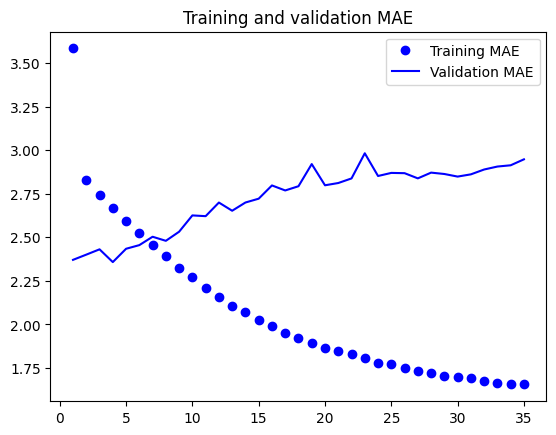

In [14]:
# Plotting results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

We achieve a test MAE of 2.50 degrees (a 4.8% improvement over the baseline) and a 2.3575 validation mae (a 3.5% improvement over the baseline). You can see that the added layer does improve the results a bit, though not dramatically. You may be seeing diminishing returns from increasing network capacity at this point.

### Going even further

There are many other things you could try in order to improve performance on the temperature-forecasting problem:

* Adjust the number of units in each recurrent layer in the stacked setup, as well as the amount of dropout. The current choices are largely arbitrary and thus probably suboptimal.

* Adjust the learning rate used by the RMSprop optimizer, or try a different optimizer.

* Try using a stack of Dense layers as the regressor on top of the recurrent layer, instead of a single Dense layer.

* Improve the input to the model: try using longer or shorter sequences or a different sampling rate, or start doing feature engineering.

As always, deep learning is more an art than a science. We can provide guidelines that suggest what is likely to work or not work on a given problem, but, ultimately, every dataset is unique; you’ll have to evaluate different strategies empirically. There is currently no theory that will tell you in advance precisely what you should do to optimally solve a problem. You must iterate.

In my experience, improving on the no-learning baseline by about 10% is likely the best you can do with this dataset. This isn’t so great, but these results make sense: while near-future weather is highly predictable if you have access to data from a wide grid of different locations, it’s not very predictable if you only have measurements from a single location. The evolution of the weather where you are depends on current weather patterns in surrounding locations.

In [9]:
# Training and evaluating a dropout-regularized, stacked GRU model

from tensorflow.keras.optimizers import Adam

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(64, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(64, recurrent_dropout=0.5)(x)

# Stack of Dense layers as regressor
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("stacked_gru_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer=Adam(learning_rate=1e-5), loss="mse", metrics=["mae"])

model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 120, 64)        │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,545 (174.00 KB)

 Trainable params: 44,545 (174.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("stacked_gru_dropout.keras")

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 589s 717ms/step - loss: 144.7067 - mae: 10.0390 - val_loss: 108.6216 - val_mae: 8.8956
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 581s 710ms/step - loss: 86.4298 - mae: 7.7819 - val_loss: 41.9913 - val_mae: 5.1375
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 585s 714ms/step - loss: 43.1916 - mae: 5.2110 - val_loss: 28.6164 - val_mae: 4.1669
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 584s 713ms/step - loss: 34.9815 - mae: 4.6757 - val_loss: 24.4331 - val_mae: 3.8463
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 583s 711ms/step - loss: 30.8200 - mae: 4.3737 - val_loss: 19.8807 - val_mae: 3.4511
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 578s 706ms/step - loss: 25.9136 - mae: 3.9787 - val_loss: 14.5963 - val_mae: 2.9400
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 565s 690ms/step - loss: 21.0344 - mae: 3.5432 - val_loss: 11.9540 - val_mae: 2.6657
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 566s 692ms/step - loss: 18.5386 - mae: 3.3334 - val_loss: 10.8929 - val_mae: 2.5587
Epoch

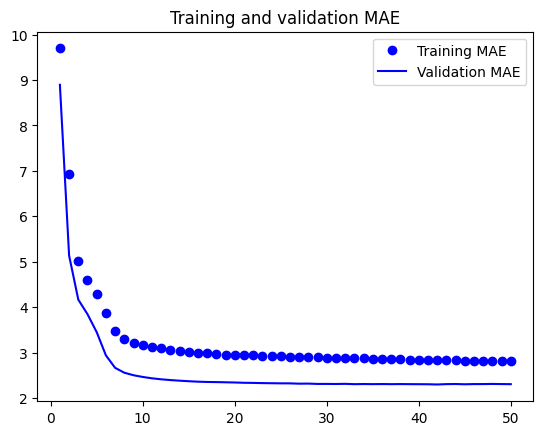

In [11]:
# Plotting results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Test Mae = 2.46, Validation Mae = 2.3066.

### Using bidirectional RNNs

The last technique we’ll look at in this section is the bidirectional RNN. A bidirectional RNN is a common RNN variant that can offer greater performance than a regular RNN on certain tasks (not weather forecasting). It’s frequently used in natural language processing—you could call it the Swiss Army knife of deep learning for natural language processing.

RNNs are notably order-dependent: they process the timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations the RNN extracts from the sequence. This is precisely the reason they perform well on problems where order is meaningful, such as the temperature-forecasting problem. A bidirectional RNN exploits the order sensitivity of RNNs: it uses two regular RNNs, such as the GRU and LSTM layers you’re already familiar with, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merges their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

Remarkably, the fact that the RNN layers in this section have processed sequences in chronological order (with older timesteps first) may have been an arbitrary decision. At least, it’s a decision we’ve made no attempt to question so far. Could the RNNs have performed well enough if they processed input sequences in antichronological order, for instance (with newer timesteps first)? Let’s try this and see what happens. All you need to do is write a variant of the data generator where the input sequences are reverted along the time dimension (replace the last line with yield samples[:, ::-1, :], targets).

In [16]:
# Training and evaluating a bidirectional LSTM

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
  1/819 ━━━━━━━━━━━━━━━━━━━━ 46:35 3s/step - loss: 162.0934 - mae: 10.5457

2025-06-21 16:27:03.974542: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


819/819 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - loss: 54.9936 - mae: 5.4623 - val_loss: 9.9893 - val_mae: 2.4569
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 9.9577 - mae: 2.4690 - val_loss: 9.3171 - val_mae: 2.3728
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - loss: 9.0665 - mae: 2.3483 - val_loss: 9.4002 - val_mae: 2.3804
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 8.4072 - mae: 2.2680 - val_loss: 9.6185 - val_mae: 2.4088
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 7.9996 - mae: 2.2109 - val_loss: 10.0171 - val_mae: 2.4605
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 7.6515 - mae: 2.1630 - val_loss: 9.9193 - val_mae: 2.4513
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - loss: 7.4065 - mae: 2.1288 - val_loss: 9.7232 - val_mae: 2.4345
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 7.1743 - mae: 2.0958 - val_loss: 10.3644 - val_mae: 2.4977
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms

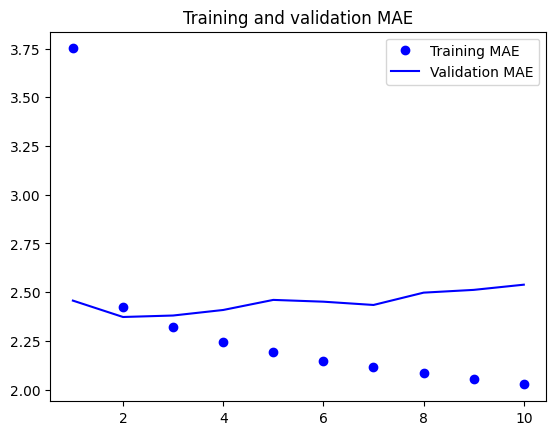

In [ ]:
# Plotting results

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

It doesn’t perform as well as the plain LSTM layer. It’s easy to understand why: all the predictive capacity must come from the chronological half of the network, because the antichronological half is known to be severely underperforming on this task (again, because the recent past matters much more than the distant past, in this case). At the same time, the presence of the antichronological half doubles the network’s capacity and causes it to start overfitting much earlier.

However, bidirectional RNNs are a great fit for text data, or any other kind of data where order matters, yet where which order you use doesn’t matter. In fact, for a while in 2016, bidirectional LSTMs were considered the state of the art on many natural language processing tasks (before the rise of the Transformer architecture, which you will learn about in the next chapter).

**Markets and machine learning**

Some people are bound to want to take the deep learning techniques introduced here and try them on the problem of forecasting the future price of securities on the stock market (or currency exchange rates, and so on). However, markets have very different statistical characteristics than natural phenomena such as weather patterns. When it comes to markets, past performance is not a good predictor of future returns—looking in the rear-view mirror is a bad way to drive. Machine learning, on the other hand, is applicable to datasets where the past is a good predictor of the future, like weather, electricity consumption, or foot traffic at a store.

Always remember that all trading is fundamentally information arbitrage: gaining an advantage by leveraging data or insights that other market participants are missing. Trying to use well-known machine learning techniques and publicly available data to beat the markets is effectively a dead end, since you won’t have any information advantage compared to everyone else. You’re likely to waste your time and resources with nothing to show for it.